In [1]:
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax.numpy as jnp
import jax

from tqdm import tqdm

from jax import config
config.update("jax_enable_x64", True)

from data import generate_data, generate_observation_matrix
from loss import create_loss
from network import init_net, compute_end_to_end, compute_factor, kwon_compress_network
from solver import train
from utils import compose, svd

## Generating Data

In [2]:
key = PRNGKey(0)

# Simulated Data
d = 100
r = 10

key, subkey = split(key)
target = generate_data(key=subkey, shape=(d, d), rank=r)

train_loss_fn = create_loss(target)
test_loss_fn = create_loss(target)

loss_fn_dict = {
    'train': train_loss_fn,
    'test': test_loss_fn
}
network_fn = compute_end_to_end

2023-10-08 22:12:36.942351: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_DEVICE_UNAVAILABLE: CUDA-capable device(s) is/are busy or unavailable
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Original Network

In [3]:
depth = 3
init_scale = 1e-2

key, subkey = split(key)

# Instatiating the original wide network
init_weights = init_net(
    key=subkey, 
    input_dim=d, 
    output_dim=d, 
    width=d, 
    depth=depth, 
    init_scale=init_scale
)

tol = 0
step_size = 1
n_outer_loops = 1000
n_inner_loops = 100

In [4]:
orig_result = train(
    init_weights=init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Compressed Network

In [5]:
# Construct surrogate target matrix for matrix completion
comp_init_weights, factors = kwon_compress_network(target=target, grad_rank=2*r, init_scale=init_scale, depth=depth)
new_comp_init_weights = [comp_init_weights[1]@comp_init_weights[0], comp_init_weights[2], comp_init_weights[4]@comp_init_weights[3]]

dlr = 1

In [6]:
comp_result = train(
    init_weights=new_comp_init_weights,
    network_fn=network_fn,
    loss_fn_dict=loss_fn_dict,
    n_outer_loops=n_outer_loops,
    step_size=step_size,
    dlr=dlr,
    tol=tol,
    n_inner_loops=n_inner_loops,
    save_weights=True
)

  0%|          | 0/1000 [00:00<?, ?it/s]

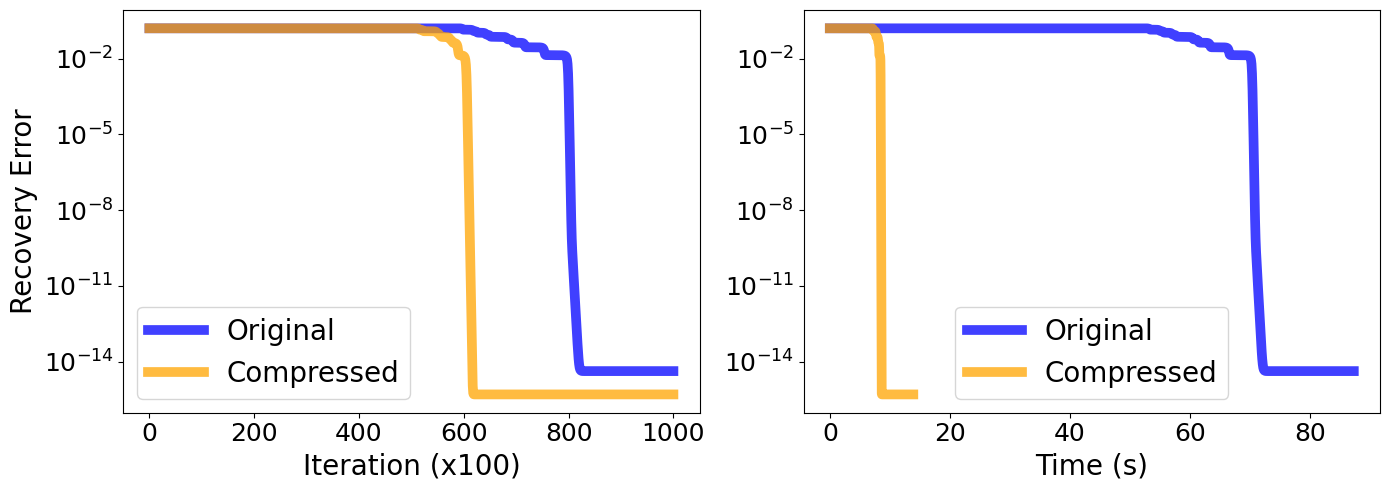

In [7]:
fig = plt.figure(figsize=(14, 5))

ax = fig.add_subplot(121)

ax.semilogy(orig_result['test_loss'], c='blue', linewidth=7, label='Original', alpha=0.75)
ax.semilogy(comp_result['test_loss'], c='orange', linewidth=7, label='Compressed', alpha=0.75)
ax.set_xlabel(rf'Iteration (x{n_inner_loops})', fontsize=20)
ax.set_ylabel('Recovery Error', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_title(rf'$\epsilon=${init_scale}')

ax = fig.add_subplot(122)
ax.semilogy(orig_result['time'], orig_result['test_loss'], c='blue', linewidth=7, label='Original', alpha=0.75)
ax.semilogy(comp_result['time'], comp_result['test_loss'], c='orange', linewidth=7, label='Compressed', alpha=0.75)
ax.set_xlabel(rf'Time (s)', fontsize=20)
#ax.set_ylabel('Recovery Error', fontsize=20)
ax.legend(fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
#ax.set_title(rf'$\epsilon=${init_scale}')

fig.tight_layout()

plt.savefig('figs/error_plot_mf_r10.png', dpi=300, bbox_inches='tight')